In [1]:
import os
import sys
import json
from tqdm import trange
from tqdm import tqdm
from skimage.util import montage
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

from medmnist.dataset import INFO, PathMNIST, ChestMNIST, DermaMNIST, OCTMNIST, PneumoniaMNIST, RetinaMNIST, BreastMNIST, OrganMNISTAxial, OrganMNISTCoronal, OrganMNISTSagittal
from medmnist.evaluator import getAUC, getACC

In [2]:
data_flag = 'pneumoniamnist'
download = True
input_root = 'tmp_data/'

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

dataclass = {
    "pathmnist": PathMNIST,
    "chestmnist": ChestMNIST,
    "dermamnist": DermaMNIST,
    "octmnist": OCTMNIST,
    "pneumoniamnist": PneumoniaMNIST,
    "retinamnist": RetinaMNIST,
    "breastmnist": BreastMNIST,
    "organmnist_axial": OrganMNISTAxial,
    "organmnist_coronal": OrganMNISTCoronal,
    "organmnist_sagittal": OrganMNISTSagittal,
}

with open(INFO, 'r') as f:
    info = json.load(f)
    task = info[data_flag]['task']
    n_channels = info[data_flag]['n_channels']
    n_classes = len(info[data_flag]['label'])

First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [3]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = dataclass[data_flag](root=input_root, split='train', transform=data_transform, download=download)
test_dataset = dataclass[data_flag](root=input_root, split='test', transform=data_transform, download=download)
nonorm_dataset = dataclass[data_flag](root=input_root, split='train', transform=transforms.ToTensor(), download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

0it [00:00, ?it/s]

4177920it [00:05, 795046.11it/s]                                                                                       


Using downloaded and verified file: .\data\pneumoniamnist.npz
Using downloaded and verified file: .\data\pneumoniamnist.npz


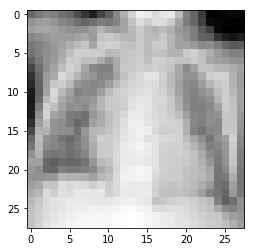

In [4]:
# visualization

img, target = nonorm_dataset[0]
if n_channels == 1:
    img = img.reshape(28, 28)
    plt.imshow(img, cmap='gray')
else:
    img = img.permute(1, 2, 0)
    plt.imshow(img)

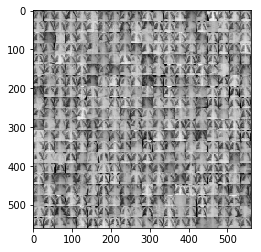

In [5]:
# montage

def process(n_channels, length=20):
    scale = length * length

    image = np.zeros((scale, 28, 28, 3)) if n_channels == 3 else np.zeros((scale, 28, 28))
    index = [i for i in range(scale)]
    np.random.shuffle(index)
    
    for idx in range(scale):
        img, _ = nonorm_dataset[idx]
        if n_channels == 3:
            img = img.permute(1, 2, 0).numpy()
        else:
            img = img.reshape(28, 28).numpy()
        image[index[idx]] = img

    if n_channels == 1:
        image = image.reshape(scale, 28, 28)
        arr_out = montage(image)
        plt.imshow(arr_out, cmap='gray')
    else:
        image = image.reshape(scale, 28, 28, 3)
        arr_out = montage(image, multichannel=3)
        plt.imshow(arr_out)
    
process(n_channels=n_channels, length=20)

Then, we define the model, object function and optimizer that we use to classify.

In [6]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Next, we can start to train and evaluate!

In [7]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.73it/s]


In [8]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                m = nn.Sigmoid()
                outputs = m(outputs)
            else:
                targets = targets.squeeze().long()
                m = nn.Softmax(dim=1)
                outputs = m(outputs)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        auc = getAUC(y_true, y_score, task)
        acc = getACC(y_true, y_score, task)
    
        print('%s  acc: %.3f  auc:%.3f' % (split, acc, auc))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  acc: 0.984  auc:0.998
test  acc: 0.851  auc:0.965
